# 1D localization using landmarks
*Maxwell Pollack*, following [Kanitscheider + Fiete 2017](https://doi.org/10.1101/231159)

An agent accelerates randomly in a periodic 1D environment of length $L$ with 2 point-like, randomly-placed, indistinguishable landmarks.

$$\begin{split}
a^t & \sim \mathcal{U}(-a_\text{max}, a_\text{max}) \\
v^t & = v_\text{max} - \bigg| \big(v_\text{max} + \sum\limits_{t'=0}^{t} a^{t'}\big) \% 4v_\text{max} - 2v_\text{max} \bigg| \\
x^t & = \bigg(\sum\limits_{t'=0}^t v^{t'}\bigg) \% L \\
\lambda^n & \sim \mathcal{U}(0,L)
\end{split}
$$

Superscripts here denote tensor indices, like time $t=\{0,1,...,T-1\}$ and landmark index $n=\{0,1\}$.

In [114]:
import torch

def simulate(T, L, nLM=2, vMax=1, aMax=0.25):
    
    a = aMax * (2*torch.rand(T) - 1)
    v = vMax - abs((a.cumsum(0) + vMax) % (4*vMax) - 2*vMax)
    x = (L*torch.rand(1) + v.cumsum(0)) % L
    landmarks = torch.rand(nLM) * L
    
    lmSense = sum(torch.relu(1 - L/2 + abs(L/2 - abs(x-landmarks.unsqueeze(1)))))
    lmMap = sum(torch.relu(1 - L/2 + abs(L/2 - abs(landmarks.unsqueeze(1) - torch.arange(float(L))))))
    input = torch.cat((lmMap.expand(T,L), lmSense.view(T,1), v.view(T,1)/vMax), 1)
    
    target = torch.relu(1 - L/2 + abs(L/2 - abs(x.unsqueeze(1)-torch.arange(float(L)))))
    
    return (input, target, landmarks, x)

## Network
A [simple RNN](https://en.wikipedia.org/wiki/Recurrent_neural_network#Elman_networks_and_Jordan_networks) is given as input a **landmark map**, a short-range **landmark proximity** sense, and the agent's **velocity**.

$$z_\text{input}^{t,i} = \begin{cases}
\sum\limits_n max\big(0,1 - \frac{L}{2} + \big|\frac{L}{2}-\big|\lambda^n - \frac{2\pi i}{L}\big|\big|\big) & 0 \leq i \lt L \\
\sum\limits_n max\big( 0, 1 - \frac{L}{2} + \big|\frac{L}{2}-\big|x^{t} - \lambda^n\big|\big|\big) & i=L \\
v^t/v_\text{max} & i=L+1
\end{cases}$$

Input neurons are indexed by $i=\{0,1,...,L+1\}$, hidden neurons by $j = \{0,1,...,2L-1\}$, and output neurons by $k = \{0,1,...,L-1\}$.

The network is trained with [Adam](https://arxiv.org/abs/1412.6980) to minimize the mean squared error between its output and the agent's **location** represented as the set of target activations

$$z_\text{target}^{t,k} = max\bigg(0,1-\big|x^t - \frac{2\pi k}{N}\big|\bigg)$$

In [ ]:
class Network(torch.nn.Module):
    def __init__(self, nInput, nHidden, nOutput):
        super(Network, self).__init__()
        self.rnn = torch.nn.RNN(nInput, nHidden, batch_first=True, nonlinearity='relu')
        self.linear = torch.nn.Linear(nHidden, nOutput)

    def forward(self, input):
        hidden = self.rnn(input)[0]
        return (torch.nn.functional.leaky_relu(self.linear(hidden)), hidden)
    
T = 256
L = 16

network = Network(L+2, 2*L, L)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

for trial in range(5*10**5):
    
    input, target, landmarks, location = simulate(T, L)
    output, hidden = network(input.unsqueeze(0))

    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

## Visualization

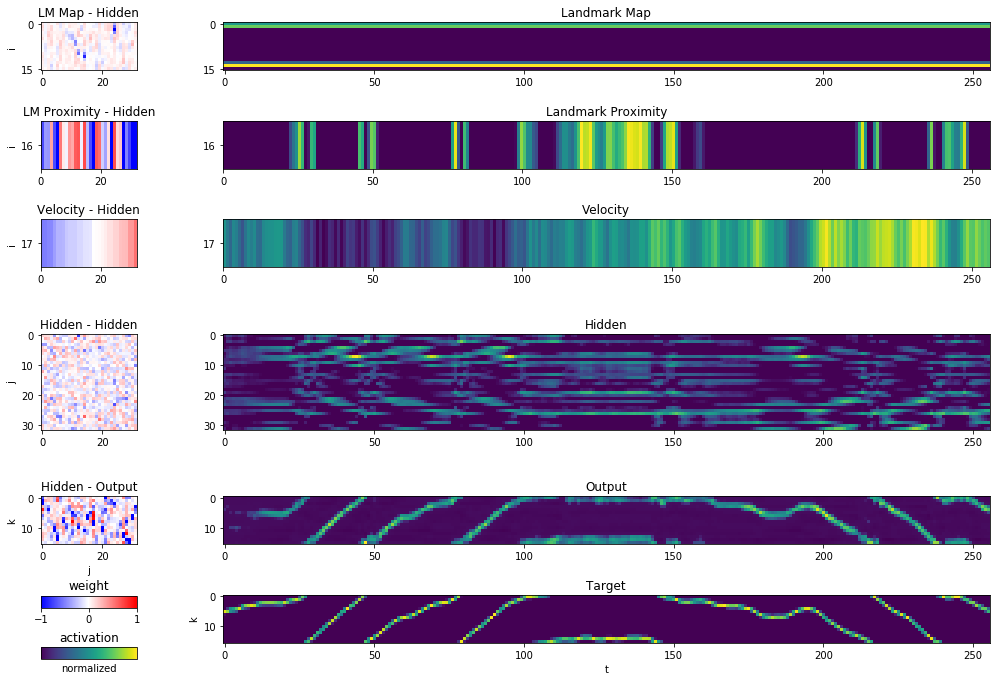

In [254]:
%matplotlib inline
import matplotlib.pyplot as plt

fig,ax = plt.subplots(6,
                      2,
                      figsize=(17,12),
                      gridspec_kw = {'height_ratios':[L,L,L,2*L,L,L],
                                     'width_ratios':[2*L,T]}
                     )
input, target, landmarks, x = simulate(10**6, L)
output, hidden = network(input.unsqueeze(0))
w_ih, w_hh, b_ih, b_hh, w_ho, b_ho = [p for p in network.parameters()]

# Sort hidden cells by their velocity input weight
hid = torch.argsort(w_ih[:,-1])

ax[0,0].imshow(w_ih.data.numpy()[hid,:L].T, cmap='bwr', vmin=-1, vmax=1)
ax[0,0].set_title('LM Map - Hidden')
ax[0,0].set_yticks([0,L-1])
ax[0,0].set_ylabel('i')
ax[0,1].imshow(input[:T,:L].data.numpy().T)
ax[0,1].set_yticks([0,L-1])
ax[0,1].set_title('Landmark Map')
ax[1,0].imshow([w_ih.data.numpy()[hid,-2]], aspect=L, extent=(0,2*L,L-0.5,L+0.5), cmap='bwr', vmin=-1, vmax=1)
ax[1,0].set_yticks([L])
ax[1,0].set_ylabel('i')
ax[1,0].set_title('LM Proximity - Hidden')
ax[1,1].imshow([input[:T,-2].data.numpy()], aspect=L, extent=(0,T,L-0.5,L+0.5))
ax[1,1].set_yticks([L])
ax[1,1].set_title('Landmark Proximity')
ax[2,0].imshow([w_ih.data.numpy()[hid,-1]], aspect=L, extent=(0,2*L,L+0.5,L+1.5), cmap='bwr', vmin=-1, vmax=1)
ax[2,0].set_yticks([L+1])
ax[2,0].set_ylabel('i')
ax[2,0].set_title('Velocity - Hidden')
ax[2,1].imshow([input[:T,-1].data.numpy()], aspect=L, extent=(0,T,L+0.5,L+1.5))
ax[2,1].set_yticks([L+1])
ax[2,1].set_title('Velocity')
ax[3,0].imshow(w_hh.data.numpy()[hid][:,hid], cmap='bwr', vmin=-1, vmax=1)
ax[3,0].set_title('Hidden - Hidden')
ax[3,0].set_ylabel('j')
ax[3,1].imshow(hidden[0,:T,hid].data.numpy().T)
ax[3,1].set_title('Hidden')
im1=ax[4,0].imshow(w_ho.data.numpy()[:,hid], cmap='bwr', vmin=-1, vmax=1)
ax[4,0].set_title('Hidden - Output')
ax[4,0].set_ylabel('k')
ax[4,0].set_xlabel('j')
im2=ax[4,1].imshow(output[0,:T].data.numpy().T)
ax[4,1].set_title('Output')
ax[5,0].axis('off')
cb1=plt.colorbar(im2, ax=ax[5,0], orientation='horizontal', aspect=8, fraction=0.15, ticks=[])
cb1.ax.set_xlabel('normalized')
cb1.ax.set_title('activation')
cb2=plt.colorbar(im1, ax=ax[5,0], orientation='horizontal', fraction=0.7, aspect=8)
cb2.ax.set_title('weight')
ax[5,1].imshow(target[:T].data.numpy().T)
ax[5,1].set_title('Target')
ax[5,1].set_ylabel('k')
ax[5,1].set_xlabel('t')
plt.show()

## Position + velocity responses of the hidden cells

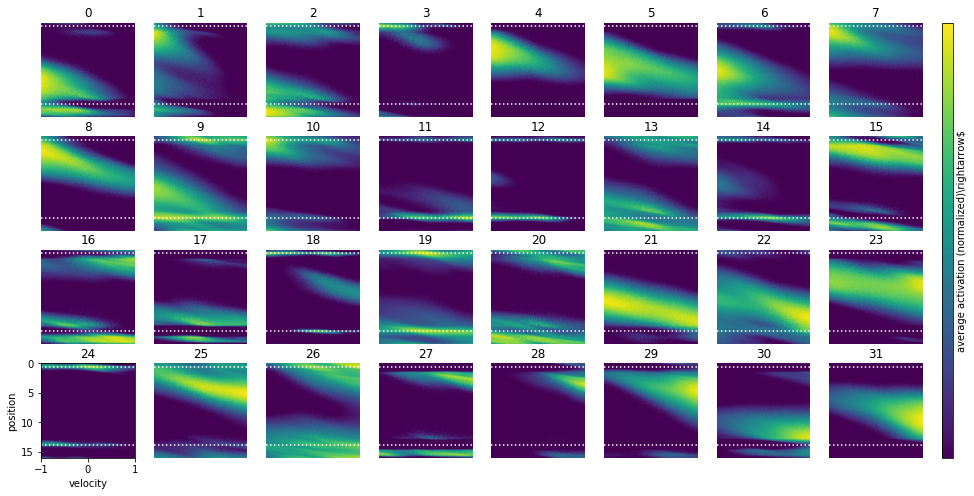

In [261]:
from math import ceil

fig,ax = plt.subplots(ceil(L/4),8,figsize=(19,8))

for cell in range(2*L):
    ax[cell//8,cell%8].set_title(str(cell))
    ax[cell//8,cell%8].axis('off')
    im = ax[cell//8,cell%8].hexbin(input[:,-1].data.numpy(),
                              x.data.numpy(),
                              C=hidden[0,:,hid[cell]].data.numpy(),
                              extent=(-1,1,0,L),
                              gridsize=256)
    ax[cell//8,cell%8].hlines(landmarks.data.numpy(),
                              xmin=-1,
                              xmax=1,
                              color='w',
                              linestyles='dotted')
    ax[cell//8,cell%8].invert_yaxis()

ax[-1,0].axis('on')
ax[-1,0].set_ylabel('position')
ax[-1,0].set_xlabel('velocity')
plt.colorbar(im, ax=ax, pad=0.018, ticks=[], aspect=40).ax.set_ylabel(r'average activation (normalized)$\rightarrow$')
plt.show()